# Refutation & Evaluation

**Objetivo:** Select the best estimate


# Dependencies

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from config import TREATMENT, OUTCOME
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.base import clone
from catboost import CatBoostClassifier, CatBoostRegressor

from utils.potential_outcomes import (
    get_metrics,
    individual_dose_response_curve,
    average_dose_response_curve,
)

from utils.preprocessing import create_stratification_split_col
from utils.estimates import logistic_regression_estimation, s_learner_estimation, iptw_estimation
from modules.iptw import ContinuousIPTW

import warnings
warnings.filterwarnings("ignore")

# Environment variables

In [2]:
CONTROLS_PATH = "data/controls.txt"
OUTCOME_CAUSES_PATH = "data/outcome_causes.txt"

In [3]:
step = 1
bin_edges = np.arange(0, 100+step, step)

# Utils

In [4]:
def random_var(
    data_var=None, distribution="permutation", sample_size=100, random_state=42
):
    np.random.seed(random_state)
    if distribution == "permutation":
        var_random = np.random.permutation(data_var)
    if (distribution == "uniform") and (data_var is not None):
        var_random = np.random.random_integers(
            low=data_var.min(), high=data_var.max(), size=sample_size
        )
    if (distribution == "normal") and (data_var is not None):
        var_random = np.random.normal(
            loc=data_var.mean(), scale=data_var.std(), size=sample_size
        )
    if (distribution == "normal") and (data_var is None):
        var_random = np.random.normal(loc=0.0, scale=1.0, size=sample_size)
    return var_random

In [34]:
def get_ci_refutation_results(
    refutation,
    estimation_method,
    train_df,
    n_iterations,
    intervention_df,
    intervention_values,
    adjustment_set,
    n_variables_common_cause=5,
    confidence_level=0.95
):

    average_dose_response_curves = []
    for i in range(n_iterations):
        # Create a bootstrapped dataset
        adjustment_set_iter = adjustment_set
        features_model = adjustment_set + [TREATMENT]
        X_train_iter, y_train_iter = (
            train_df[features_model],
            train_df[[OUTCOME]],
        )
        intervention_df_copy = intervention_df.copy()
        if refutation == "placebo_treatment_replacement":
            random_treatment = random_var(
                X_train_iter[TREATMENT],
                distribution="permutation",
                sample_size=X_train_iter.shape[0],
                random_state=i,
            )
            X_train_iter[TREATMENT] = random_treatment
        
        if refutation == "random_common_cause":
            common_causes = []
            for cc_i in range(1, n_variables_common_cause + 1):
                random_confounder = random_var(
                    None,
                    distribution="normal",
                    sample_size=X_train_iter.shape[0],
                    random_state=cc_i + i,
                )
                common_cause_name = "random_confounder_" + str(cc_i)
                X_train_iter[common_cause_name] = random_confounder
                common_causes.append(common_cause_name)

            features_model = adjustment_set + [TREATMENT] + common_causes
            adjustment_set_iter = adjustment_set + common_causes
            for cc_i, common_cause_name in enumerate(common_causes):
                random_confounder_test = random_var(
                    None,
                    distribution="normal",
                    sample_size=intervention_df_copy.shape[0],
                    random_state=cc_i * i,
                )
                intervention_df_copy[common_cause_name] = random_confounder_test

        # train model and predict POs
        if estimation_method == "logistic_reg":
            train_iter = pd.concat([X_train_iter, y_train_iter], axis=1) 
            log_regression_boostrap = logistic_regression_estimation(train_iter, adjustment_set_iter)
            individual_potential_outcome = individual_dose_response_curve(
                df_eval=intervention_df_copy,
                treatment_interventions=intervention_values,
                predictive_model=log_regression_boostrap, 
                modelling_features=adjustment_set_iter + [TREATMENT], 
                feature_counterfactual=TREATMENT, 
                model_package="statsmodels",
                task="classification"
            )

        elif estimation_method == "s_learner":
            s_learner_params = {
                "n_estimators": 200,
                "depth": None,
                "min_data_in_leaf": round(X_train_iter.shape[0]*0.01),
                "learning_rate": 0.01,
                "subsample": 1,
                "rsm": 1,
                "objective": "Logloss",
                "silent": True,
                "l2_leaf_reg": 3
            }
            s_learner_model = CatBoostClassifier(**s_learner_params)
            s_learner_boostrap = s_learner_estimation(X_train_iter, y_train_iter, adjustment_set_iter+[TREATMENT], s_learner_model)
            individual_potential_outcome = individual_dose_response_curve(
                df_eval=intervention_df_copy,
                treatment_interventions=intervention_values,
                predictive_model=s_learner_boostrap, 
                modelling_features=adjustment_set_iter + [TREATMENT], 
                feature_counterfactual=TREATMENT, 
                model_package="sklearn",
                task="classification"
            )

        elif estimation_method == "iptw":
            init_params = {
                "n_estimators": 200,
                "depth": None,
                "min_data_in_leaf": round(X_train_iter.shape[0]*(2/3)*0.01),
                "learning_rate": 0.01,
                "subsample": 1,
                "rsm": 1,
                "objective": "RMSE",
                "silent": True,
                "l2_leaf_reg": 3
            }
            model_propensity = CatBoostRegressor(**init_params)
            bin_edges_contained = intervention_values
            bin_edges_contained[0] = -1
            weighter = ContinuousIPTW(model=model_propensity, n_folds=5, random_state=42)
            controls = [c for c in features_model if c != TREATMENT]
            weights_iptw = weighter.compute_weights(X_train_iter[controls], X_train_iter[[TREATMENT]], bin_edges_contained)

            iptw_params = {
                "n_estimators": 200,
                "depth": None,
                "min_data_in_leaf": round(X_train_iter.shape[0]*0.01),
                "learning_rate": 0.01,
                "subsample": 1,
                "rsm": 1,
                "objective": "Logloss",
                "silent": True,
                "l2_leaf_reg": 3
            }
            iptw_model = CatBoostClassifier(**iptw_params)
            iptw_boostrap = iptw_estimation(X_train_iter, y_train_iter, weights_iptw, features_model, iptw_model)
            individual_potential_outcome = individual_dose_response_curve(
                df_eval=intervention_df_copy,
                treatment_interventions=intervention_values,
                predictive_model=iptw_boostrap, 
                modelling_features=adjustment_set_iter + [TREATMENT], 
                feature_counterfactual=TREATMENT, 
                model_package="sklearn",
                task="classification"
            )

        # get results
        individual_potential_outcomes_resample = np.array(individual_potential_outcome)
        average_dose_response_curve_resample = np.mean(individual_potential_outcomes_resample, axis=0)
        average_dose_response_curves.append(average_dose_response_curve_resample)

    # Convert predictions to a NumPy array
    average_dose_response_curves = np.array(average_dose_response_curves)

    # Average
    average_dose_response_curve = np.mean(average_dose_response_curves, axis=0)


    # Confidence intervals
    lower_bound_dose_response = np.percentile(average_dose_response_curves, (1 - confidence_level) * 100, axis=0)
    upper_bound_dose_response = np.percentile(average_dose_response_curves, confidence_level * 100, axis=0)
    
    return average_dose_response_curve, lower_bound_dose_response, upper_bound_dose_response

# Data

In [14]:
with open(CONTROLS_PATH) as f:
    controls = f.read().split("\n")
controls = [c for c in controls if c != ""]
controls

['years_since_default',
 'n_refin',
 'loss_given_default',
 'n_loans',
 'n_cards',
 'debt_cirbe',
 'default_debt_amount']

In [15]:
with open(OUTCOME_CAUSES_PATH) as f:
    outcome_causes = f.read().split("\n")
outcome_causes = [c for c in outcome_causes if c != ""]
outcome_causes

['years_history']

In [16]:
df_original = pd.read_parquet("data/synthetic_data.parquet")
df = df_original[controls + outcome_causes + [TREATMENT, OUTCOME]]
train_propagated = pd.read_parquet("data/synthetic_train_data_propagated.parquet")

# Split

In [17]:
strat_feature = create_stratification_split_col(df, TREATMENT, OUTCOME)
train, test = train_test_split(
    df, test_size=0.2, random_state=42, 
    stratify=strat_feature,
)

X_train_propagated, y_train_propagated = (
    train_propagated[controls + [TREATMENT]],
    train_propagated[[OUTCOME]],
)

X_train, y_train = (
    train.drop(columns=[OUTCOME]).copy(),
    train[[OUTCOME]],
)
X_test, y_test = (
    test[X_train.columns],
    test[[OUTCOME]],
)
print(X_train_propagated.shape, X_train.shape, X_test.shape)

(23701, 8) (12000, 9) (3000, 9)


# Refutation and Evaluation

In [18]:
methods = ["logistic_reg", "s_learner"]

colors = {
    "logistic_reg": "orange",
    "s_learner": "darkblue",
}

## Placebo Treatment Replacement

Optimization terminated successfully.
         Current function value: 0.616656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616664
         Iterations 6


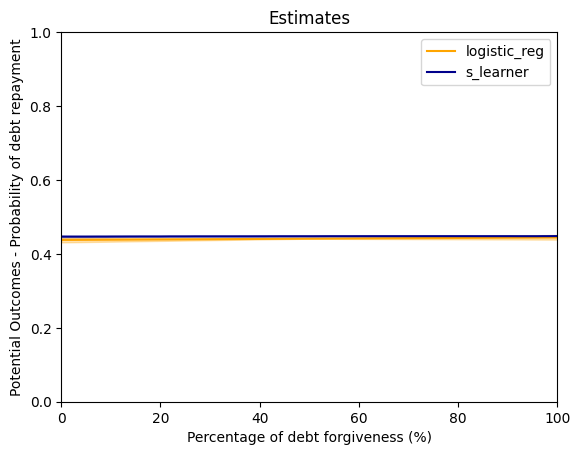

In [19]:

for est_method in methods:
    average_dose_response_curve_method, lower_ci, upper_ci = get_ci_refutation_results(
        refutation="placebo_treatment_replacement",
        estimation_method=est_method,
        train_df=train_propagated.copy(),
        n_iterations=5,
        intervention_df=test.copy(),
        intervention_values=bin_edges,
        adjustment_set=controls,
        n_variables_common_cause=5,
        monotone_constrains=None,
        confidence_level=0.95
    )

    plt.plot(
        bin_edges,
        average_dose_response_curve_method,
        label=est_method,
        color=colors[est_method],
    )
    plt.fill_between(
        bin_edges,
        lower_ci,
        upper_ci,
        alpha=0.3,
        color=colors[est_method],
    )

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("Potential Outcomes - Probability of debt repayment")
plt.title("Estimates")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

## Random Common Cause

Optimization terminated successfully.
         Current function value: 0.486684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486585
         Iterations 6


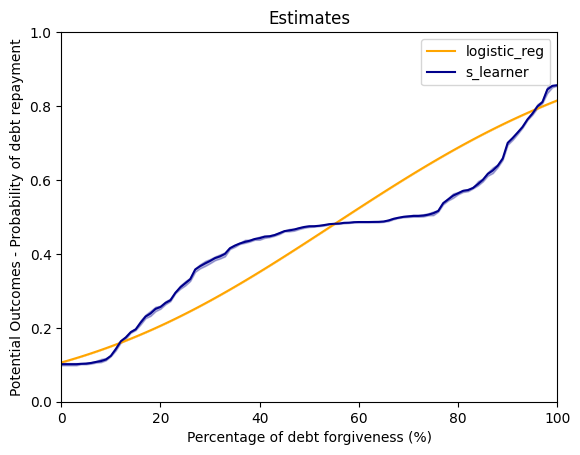

In [35]:
for est_method in methods:
    average_dose_response_curve_method, lower_ci, upper_ci = get_ci_refutation_results(
        refutation="random_common_cause",
        estimation_method=est_method,
        train_df=train_propagated.copy(),
        n_iterations=5,
        intervention_df=test.copy(),
        intervention_values=bin_edges,
        adjustment_set=controls,
        n_variables_common_cause=5,
        confidence_level=0.95
    )

    plt.plot(
        bin_edges,
        average_dose_response_curve_method,
        label=est_method,
        color=colors[est_method],
    )
    plt.fill_between(
        bin_edges,
        lower_ci,
        upper_ci,
        alpha=0.3,
        color=colors[est_method],
    )

plt.xlabel("Percentage of debt forgiveness (%)")
plt.ylabel("Potential Outcomes - Probability of debt repayment")
plt.title("Estimates")
plt.legend()
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.show()

## E-values

## QINI curves